In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

In [2]:
def compute_ring_radius(p,q):
    a = np.pi/p
    b = np.pi/q
    r0 = np.sqrt(np.cos(a+b)/np.cos(a-b))
    return r0

def hyperbolic_distance(kappa, z1, z2):
    d = kappa * np.arccosh(1 + (2 * (abs(z1 - z2))**2 / ((1 - abs(z1)**2) * (1 - abs(z2)**2))))
    return d

def unit_cell_positions(p,q):
    r0 = compute_ring_radius(p,q)
    vertices_positions = []
    for k in range(p):
        vertices_positions.append(r0 * np.exp(1j * np.pi * (2*k-1) / p))
    
    d0 = 0.66
    for k in range(p):
        vertices_positions.append(d0 * np.exp(1j * np.pi * (2*k-1) / p))
    
    return vertices_positions

def inner_ring_coords(p,q):
    vertices_positions = unit_cell_positions(p,q)
    vertices_coords = []
    for k in range(len(vertices_positions)):
        x,y = vertices_positions[k].real, vertices_positions[k].imag
        vertices_coords.append(np.array([x,y]))
    return vertices_coords

def euclidean_distance(z1, z2):
    d = abs(z1 - z2)
    return d

def rotation_matrix(phi):
    return np.array([[np.exp(1j*phi/2), 0], [0, np.exp(-1j*phi/2)]])

def Fuchsian_generators(p_B, q_B):
    alpha = 2* np.pi/ p_B
    beta = 2* np.pi/ q_B
    sigma = np.sqrt((np.cos(alpha) + np.cos(beta)) / (1 + np.cos(beta)) )
    gamma1 = 1/(np.sqrt(1-sigma**2)) * np.array([[1, sigma], [sigma,1]])
    FG_generators = []
    for mu in range(0,int(p_B/2)):
        FG_generators.append(rotation_matrix(mu*alpha) @ gamma1 @ rotation_matrix(-mu*alpha))
    for j in range(int(p_B/2)):
        FG_generators.append(np.linalg.inv(FG_generators[j]))
    return FG_generators 

def create_new_vertex(vertex_position, translation_matrix):
    v = translation_matrix @ np.array([vertex_position, 1])
    new_vertex_position = v[0]/v[1]
    return new_vertex_position

vertices_labels = {}
edge_labels = {}  # Dictionary to store edge labels


def plot_vertices_with_edges(vertices):
    d0 = hyperbolic_distance(kappa, vertices[0], vertices[1])
    coords = [(v.real, v.imag) for v in vertices]
  
    G = nx.Graph()
    for idx, pos in enumerate(coords):
        G.add_node(idx, pos=pos, label=True)
        
    edge_count = 0  # Counter for edge labels
    
    for i, pos1 in enumerate(vertices):
        for j, pos2 in enumerate(vertices[i+1:], start=i+1):
            if hyperbolic_distance(kappa, pos1, pos2) < (d0 + 0.1):
                G.add_edge(i, j, with_labels=True)
                edge_labels[(i, j)] = edge_count  # Assign integer label
                edge_count += 1
    
    pos_dict = {idx: pos for idx, pos in enumerate(coords)}
    
    # Set figure size
    plt.figure(figsize=(20, 20))  # Adjust the width and height as needed
    
    # Draw the graph
    nx.draw(
        G,
        pos=pos_dict,
        node_size=50,  # Adjust node size
        node_color="lightblue",
        with_labels=True,
        font_size=6,  # Increase font size for node labels
        font_color="black"
    )
    
    # Draw edge labels
    nx.draw_networkx_edge_labels(
        G,
        pos=pos_dict,
        edge_labels=edge_labels,
        font_size=10,  # Increase font size for edge labels
        label_pos=0.5,  # Adjust edge label position (closer to the center of edges)
    )
    
    plt.axis("equal")  # Ensure equal scaling
    plt.show()  # Display the plot
    
    return G

def get_edge_labels_for_vertex(G, vertex, edge_labels):
    # Get all edges incident to the given vertex
    incident_edges = list(G.edges(vertex))
    
    # Retrieve the labels for these edges from the edge_labels dictionary
    incident_edge_labels = {edge: edge_labels[tuple(sorted(edge))] for edge in incident_edges}
    
    return incident_edge_labels.values()

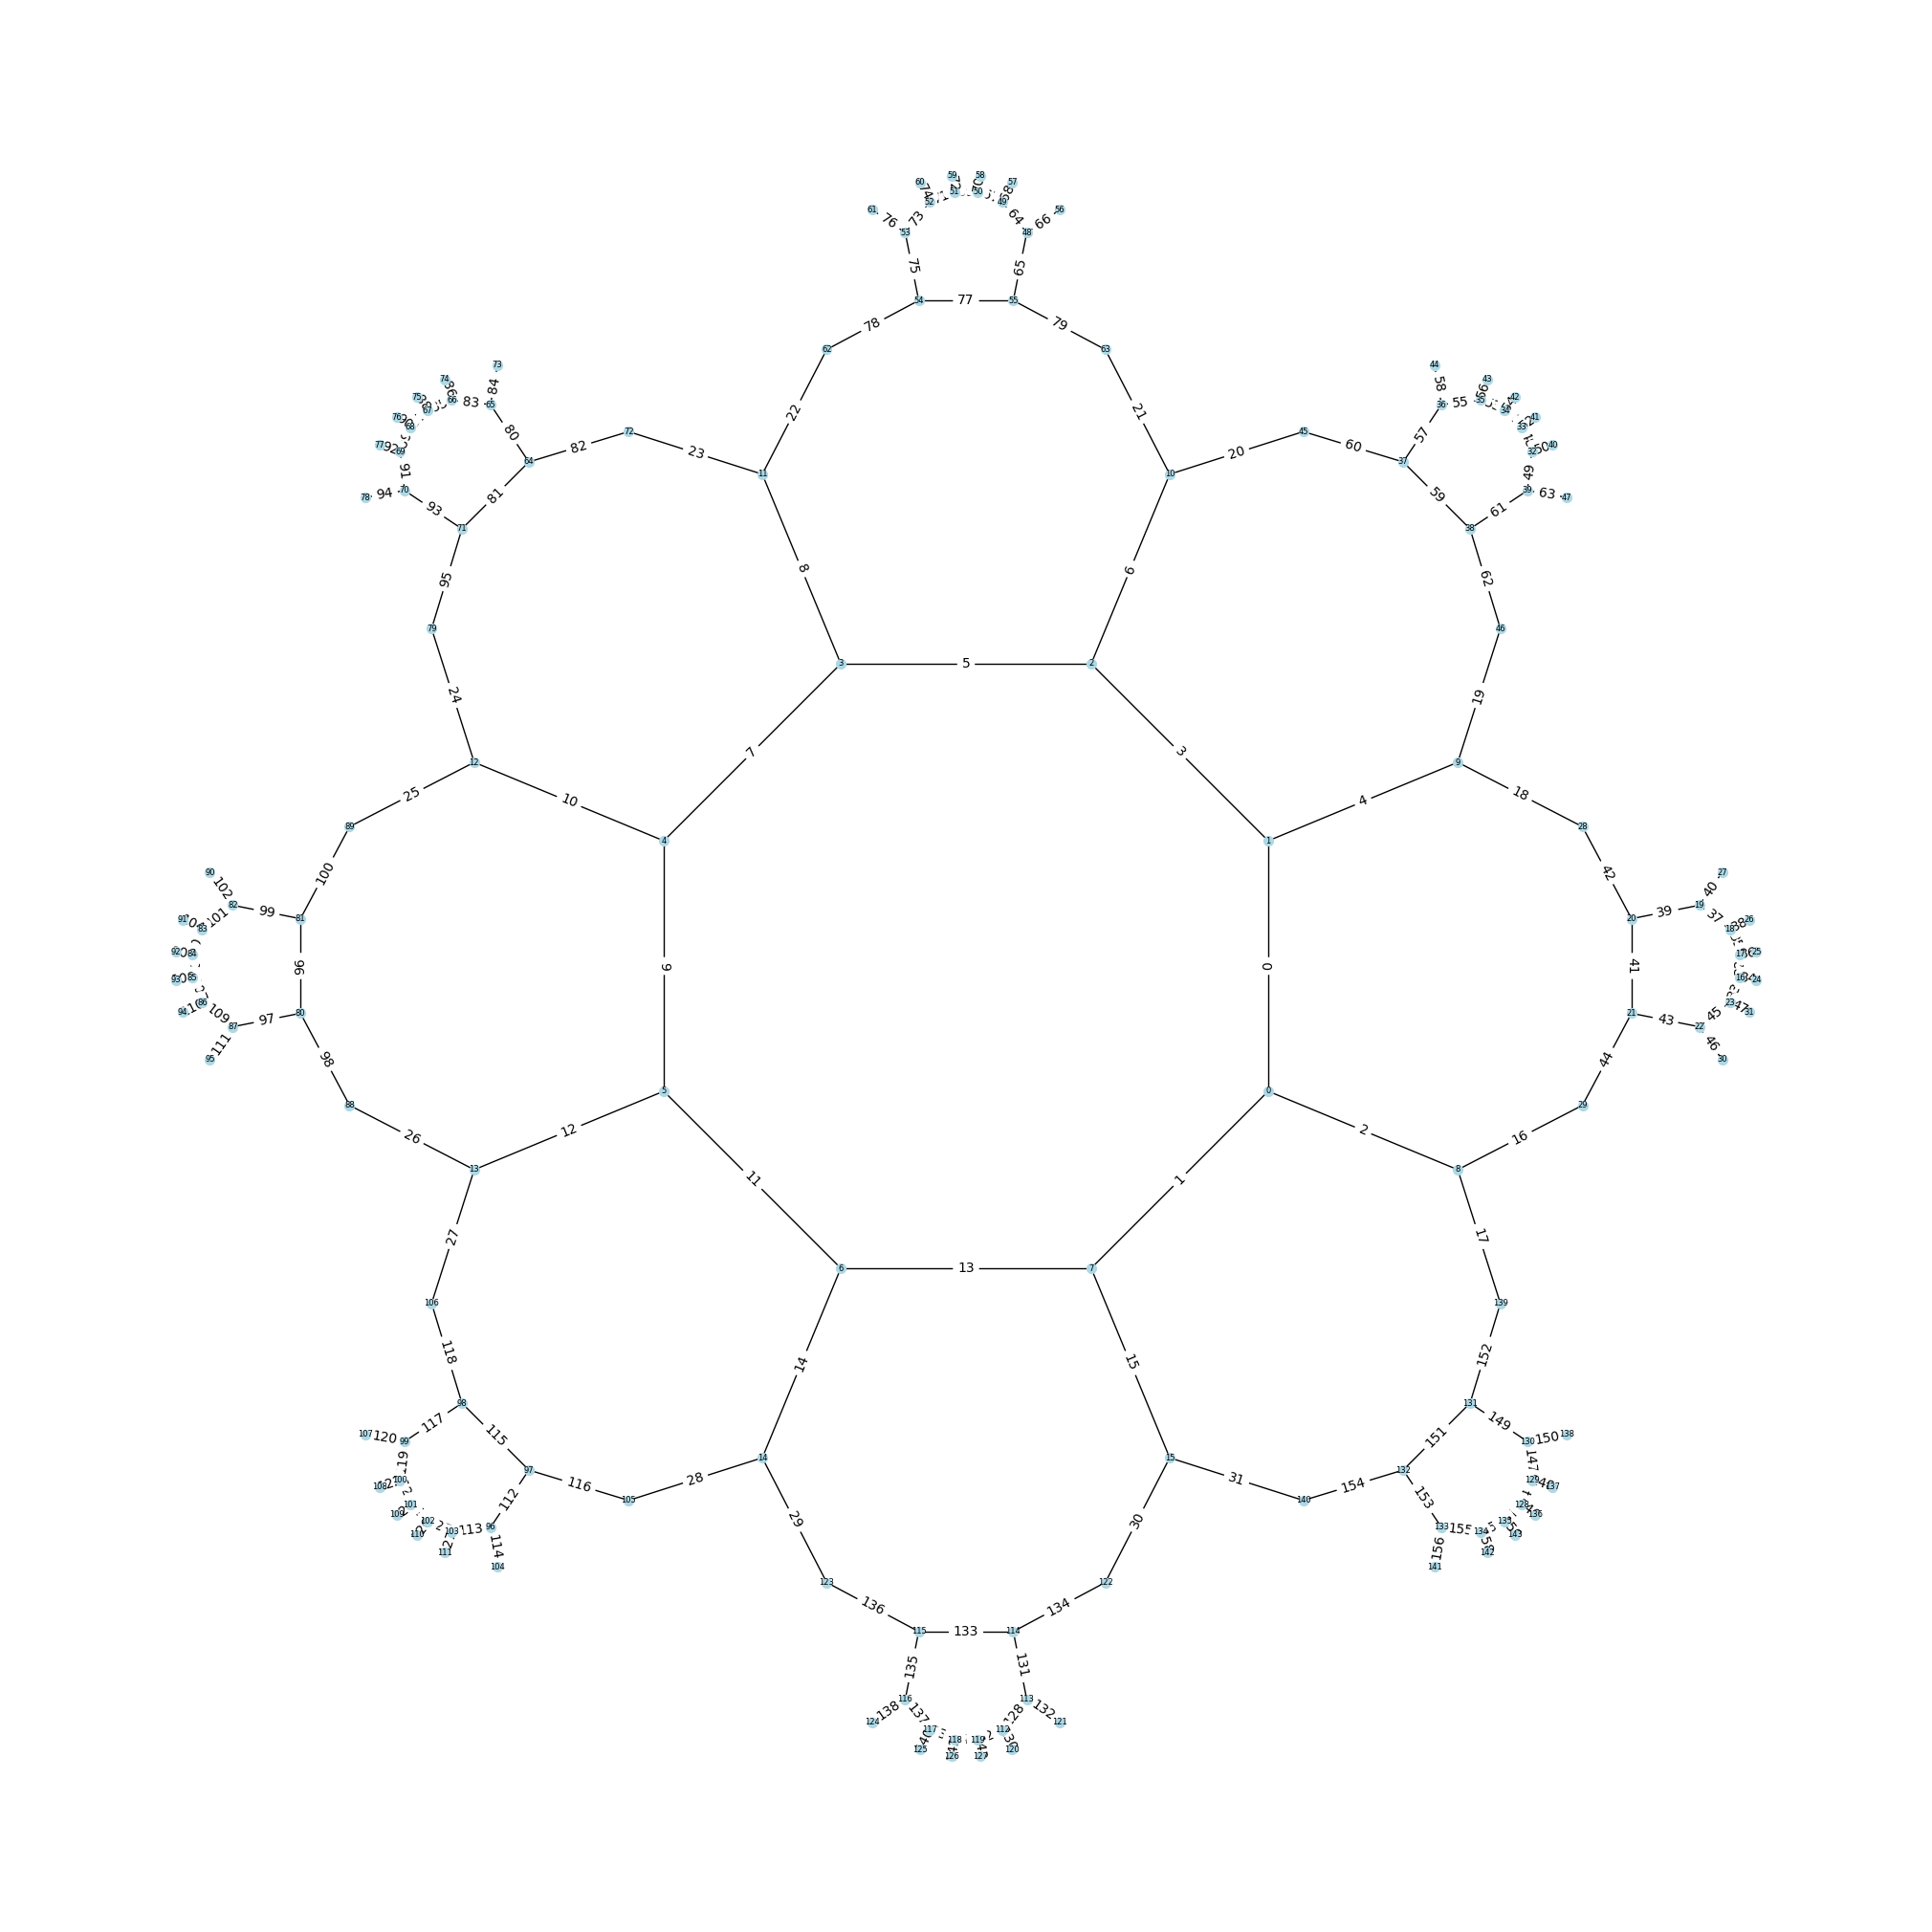

In [3]:
p = 8
q = 3

p_B = 8
q_B = 8
kappa = 1

unit_cell = unit_cell_positions(p,q)
Bolza_generators = Fuchsian_generators(p_B, q_B)

outer_ring = []
# 
# more_vertices = []
# 
for generator in Bolza_generators:
    for vertex in unit_cell:
        new_vertex = create_new_vertex(vertex, generator)
    # Check if new_vertex is not in any of the vertices in D
        if all(hyperbolic_distance(1,new_vertex,vertex)> 0.01 for vertex in unit_cell+outer_ring):
            outer_ring.append(new_vertex)
            
# for j in range(len(Bolza_generators)):
#     for k in range(len(Bolza_generators)):
#         if k != j:
#             for vertex in unit_cell+ outer_ring:
#                 new_vertex = create_new_vertex(vertex, Bolza_generators[j] @ Bolza_generators[k])
#                 if all(hyperbolic_distance(1,new_vertex,vertex)> .5 for vertex in unit_cell+outer_ring):
#                     more_vertices.append(new_vertex)


final_vertices = unit_cell + outer_ring

circuit_graph = plot_vertices_with_edges(final_vertices)

In [4]:
def generate_circuit(graph):
    num_vertices = len(graph.nodes())
    num_edges = len(graph.edges())
    
    vertices_qubits = QuantumRegister(num_vertices, 'vertices_qubits')
    edges_qubits = QuantumRegister(num_edges, 'edges_qubits')
    cr = ClassicalRegister(num_vertices, 'cr')
    # We will still add classical registers for plaquettes
    qc = QuantumCircuit()
    qc.add_register(vertices_qubits)
    qc.add_register(edges_qubits)
    qc.add_register(cr)
    

    for j in [5, 149]:
        qc.x(edges_qubits[j])
    
    
    for v in range(len(graph.nodes())):
        incident_edges = get_edge_labels_for_vertex(graph, v, edge_labels)
        for edge in incident_edges:
            # qc.h(edges_qubits[edge])
            # qc.cx(edges_qubits[edge], vertices_qubits[v])
            # qc.h(edges_qubits[edge])
            qc.cx(edges_qubits[edge], vertices_qubits[v])
        qc.barrier()
        
    for v in range(len(graph.nodes())):
        qc.measure(vertices_qubits[v], cr[v])
    
        
    # qubits_of_interest = [edges_qubits[5], vertices_qubits[2], vertices_qubits[3], edges_qubits[149], vertices_qubits[130], vertices_qubits[131]]

    # filtered_circuit = QuantumCircuit(*qubits_of_interest, cr[0], cr[1])
    
    # # Copy only the instructions that involve the selected qubits
    # for instruction in qc.data:
    #     qubits, clbits = instruction[1], instruction[2]
    #     if any(q in qubits_of_interest for q in qubits):
    #         filtered_circuit.append(instruction[0], qubits, clbits)
    # 
    # # Draw the filtered circuit
    # filtered_circuit.draw("mpl")
    
    return qc
        

In [5]:
qcc= generate_circuit(circuit_graph)
# qcc.draw(output='mpl')

In [6]:
simulator = AerSimulator()
result = simulator.run(qcc, shots=1024).result().get_counts()
sorted = {k: v for k, v in sorted(result.items(), key=lambda item: item[1])}
print(sorted)
    

{'011111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100': 1, '000000001000111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100': 1, '011101000111010100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100': 1, '000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100': 1, '000000000001100100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100': 1, '000000000001001100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100': 1, '00000000000101100000000000000000000000000000000000000000000000000000000000000000000000000000

In [7]:
quasi_dist = result.quasi_dists[0].binary_probabilities()
plot_histogram(quasi_dist)

AttributeError: 'Counts' object has no attribute 'quasi_dists'